#**Predictive Maintenance** : **Data Analysis & Time-Series Forecasting**


In [ ]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import ot
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline
pd.set_option("display.max_columns",None)

In [ ]:
telemetry_df = pd.read_csv("/content/PdM_telemetry.csv")
errors_df = pd.read_csv("/content/PdM_errors.csv")
maint_df = pd.read_csv("/content/PdM_maint.csv")
failure_df = pd.read_csv("/content/PdM_failures.csv")
machines_df = pd.read_csv("/content/PdM_machines.csv")

In [ ]:
#Date and Time Formatting, Sorting based on Date for better readability
tables = [telemetry_df,errors_df,maint_df,failure_df]
for df in tables:
  df["datetime"] = pd.to_datetime(df["datetime"], format = "%Y-%m-%d %H:%M:%S")
  df.sort_values(["datetime","machineID"],inplace=True, ignore_index = True)

In [ ]:
# Filtrons pour ne conserver que les lignes qui ne sont PAS du 1er janvier
telemetry_df = telemetry_df[telemetry_df['datetime'].dt.month != 1]
telemetry_df = telemetry_df[telemetry_df['datetime'].dt.day != 1]

In [ ]:
telemetry_df = telemetry_df.reset_index(drop=True)
telemetry_df['heure'] = telemetry_df['datetime'].dt.hour

In [ ]:
"""# Sélection des colonnes d'intérêt
features = ['volt', 'rotate', 'pressure', 'vibration']
telemetry_df_subset = telemetry_df[features]

# Calcul de l'IQR pour les colonnes sélectionnées
Q1 = telemetry_df_subset.quantile(0.25)
Q3 = telemetry_df_subset.quantile(0.75)
IQR = Q3 - Q1

# Identification des outliers
outliers = ((telemetry_df_subset < (Q1 - 1.5 * IQR)) | (telemetry_df_subset > (Q3 + 1.5 * IQR)))

# Correction des outliers, par exemple en les remplaçant par la médiane
for column in outliers.columns:
    median_value = telemetry_df_subset[column].median()
    telemetry_df.loc[outliers[column], column] = median_value

# Notez que nous avons mis à jour telemetry_df directement
telemetry_df"""

In [ ]:
telemetry_failure_df = pd.merge(telemetry_df, failure_df, on=['datetime', 'machineID'], how='left')
telemetry_failure_df.fillna(0, inplace=True)
normal_df = telemetry_failure_df[telemetry_failure_df['failure'] == 0]
anormal_df = telemetry_failure_df[telemetry_failure_df['failure'] != 0]

In [ ]:
normal_df

In [ ]:
anormal_df

In [ ]:
# Groupement des données filtrées par date et identifiant de machine
grouped = telemetry_failure_df.groupby([telemetry_failure_df['datetime'].dt.date, 'machineID'])

# Initialisation de la liste pour stocker les DataFrames
daily_dfs = []

# Itération sur chaque groupe et ajout à la liste
for _, group_df in grouped:
    daily_dfs.append(group_df)


In [ ]:
daily_dfs[4400]

In [ ]:
for i in range (len(daily_dfs)):
  daily_dfs[i].drop_duplicates(subset='datetime', keep='first', inplace=True)

# **Barycentre**

In [ ]:
'''Pour chaque feature ['volt', 'rotate', 'pressure', 'vibration'] l'on détermine
  la moyenne des données sur une même heure pour toutes les 100 machines
  La même opération repétée sur 24h nous donne un vecteur barycentre'''

def barycentre(feature):
  barycentre = np.array(telemetry_df.groupby('heure')[feature].mean())
  return barycentre

In [ ]:
features = ['volt', 'rotate', 'pressure', 'vibration']
barycentres = {'volt' : barycentre('volt' ) , 'rotate' : barycentre('rotate') , 'pressure' : barycentre('pressure' ) , 'vibration' : barycentre('vibration' ) }
barycentres

{'volt': array([170.71461526, 170.81854758, 170.74779588, 170.76948548,
        170.70148986, 170.75722843, 170.72981043, 170.73685236,
        170.91908048, 170.77527471, 170.72947009, 170.78144677,
        170.5105116 , 170.84394535, 170.89092119, 170.7645248 ,
        170.74964861, 170.81269914, 170.68470188, 170.84694061,
        170.78444713, 170.71378011, 170.70562933, 170.73230352]),
 'rotate': array([446.46738004, 446.89946983, 446.07814824, 446.7698981 ,
        446.86850505, 446.88829262, 446.42507881, 446.96081991,
        446.69437498, 446.82868651, 446.60202836, 446.83592146,
        446.33963161, 446.68724918, 446.75771474, 446.78395806,
        446.01926017, 446.55862411, 447.30909272, 446.68926448,
        446.66152108, 446.70649786, 446.59550958, 446.61290517]),
 'pressure': array([100.81397355, 100.88552581, 100.93152098, 100.80742866,
        100.73831589, 100.91411627, 100.97727978, 100.87257534,
        100.84711014, 100.87491389, 100.80918735, 100.84394268,
      

In [ ]:
poids = np.array(telemetry_df[features ].var())
#poids = np.array(normal_df[features ].std())
poids = poids / poids.sum()
poids

array([0.07604881, 0.87630238, 0.03852599, 0.00912282])

In [ ]:
def barycentre_show(daily_dfs, feature):
  # Plotting
  plt.figure(figsize=(10, 6))
  for i in range(0,500,100):
    df = daily_dfs[i]
    plt.plot(df['heure'], df[feature], marker='o')
    plt.plot(df['heure'], barycentres[feature], marker='*')
  id = df['machineID'].unique()[0]
  plt.title(f'Machine N0.{id} {feature} of the day')
  plt.xlabel('Hour of the Day')
  plt.ylabel(f'{feature}')
  plt.show()

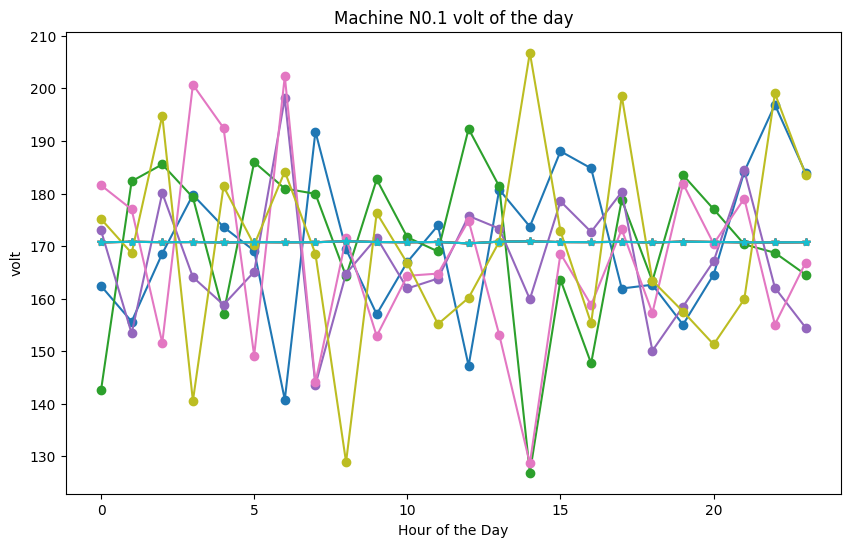

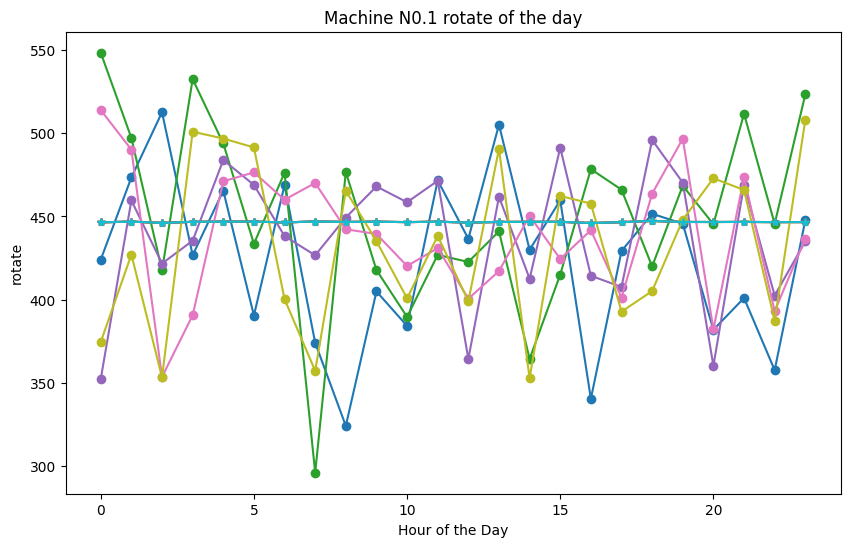

In [ ]:
df = daily_dfs
barycentre_show(df, features[0])
barycentre_show(df, features[1])

# **Distance de Sinkhorn**

In [ ]:
'''L'on determiner la distance de sinkhorn entre le barycentre et les données journalières de chaque
  machine pour tous les feautures ['volt', 'rotate', 'pressure', 'vibration']

  Pour la suite l'on transforme d'abord les distances en utilisant un logarithme, puis l'on Fit une distribution normale
  sur les distances log-transformées , et enfin l'on détermine un seuil (ici, le 95e percentile de cette distribution).
  Ce seuil est ensuite retransformé dans l'échelle d'origine des distance.

'''

def seuil(feature):
    distances = []

    b = barycentre(feature).reshape(-1, 1)  # Ajout de reshape(-1, 1) ici aussi
    b /= b.sum()


    for data in daily_dfs:
        a = np.array(data[feature]).reshape(-1, 1)  # Ajout de reshape(-1, 1)
        a /= a.sum()

        # Calculate the cost matrix between the elements of a and b
        M = ot.dist(a, b, metric='euclidean')

        # Regularization term
        lambda_ = 1e-2  # You can adjust this parameter

        # Compute the Sinkhorn distance
        sinkhorn_distance = ot.sinkhorn2(a, b, M, lambda_)[0]
        distances.append(sinkhorn_distance)

    # Données {di}
    data = np.array(distances)  # Votre ensemble de données ici

    # Log-transform des données
    log_data = np.log(data)

    # Fit une distribution normale sur les données log-transformées
    mu, sigma = stats.norm.fit(log_data)

    # Définir un percentile pour le seuil (par exemple, le 95e percentile)
    percentile = 95

    # Utiliser la CDF inverse (fonction quantile) pour obtenir le seuil sur la distribution transformée
    threshold_log_space = stats.norm.ppf(percentile / 100.0, mu, sigma)

    # Re-transformer pour obtenir le seuil dans l'espace des données original
    threshold = np.exp(threshold_log_space)

    print(f"Le seuil ϑ basé sur un ajustement log-normale est: {threshold}")

    # Tracer l'histogramme
    plt.hist(distances, bins=300, color='blue', edgecolor='black')

    # Ajouter des labels et un titre
    plt.xlabel('Distance')
    plt.ylabel('Fréquence')
    plt.title('Histogramme des distances')

    # Afficher le graphique
    plt.show()

    return threshold


In [ ]:
'''L'on determiner la distance de sinkhorn entre le barycentre et les données journalières de chaque
  machine pour tous les feautures ['volt', 'rotate', 'pressure', 'vibration']

  Pour la suite l'on transforme d'abord les distances en utilisant un logarithme, puis l'on Fit une distribution normale
  sur les distances log-transformées , et enfin l'on détermine un seuil (ici, le 95e percentile de cette distribution).
  Ce seuil est ensuite retransformé dans l'échelle d'origine des distance.

'''

def seuil(feature):
    distances = []

    b = barycentre(feature).reshape(-1, 1)  # Ajout de reshape(-1, 1) ici aussi
    b /= b.sum()
    for data in daily_dfs:
        a = np.array(data[feature]).reshape(-1, 1)  # Ajout de reshape(-1, 1)
        a /= a.sum()

        # Regularization term
        lambda_ = 1e-2  # You can adjust this parameter

        # Compute the Sinkhorn distance
        distance = np.sqrt(np.sum((a - b) ** 2))
        distances.append(distance)

    # Données {di}
    data = np.array(distances)  # Votre ensemble de données ici

    # Log-transform des données
    log_data = np.log(data)

    # Fit une distribution normale sur les données log-transformées
    mu, sigma = stats.norm.fit(log_data)

    # Définir un percentile pour le seuil (par exemple, le 95e percentile)
    percentile = 95

    # Utiliser la CDF inverse (fonction quantile) pour obtenir le seuil sur la distribution transformée
    threshold_log_space = stats.norm.ppf(percentile / 100.0, mu, sigma)

    # Re-transformer pour obtenir le seuil dans l'espace des données original
    threshold = np.exp(threshold_log_space)

    print(f"Le seuil ϑ basé sur un ajustement log-normale est: {threshold}")

    # Tracer l'histogramme
    plt.hist(distances, bins=300, color='blue', edgecolor='black')

    # Ajouter des labels et un titre
    plt.xlabel('Distance')
    plt.ylabel('Fréquence')
    plt.title('Histogramme des distances')

    # Afficher le graphique
    plt.show()

    return threshold


Le seuil ϑ basé sur un ajustement log-normale est: 0.02224790711066546


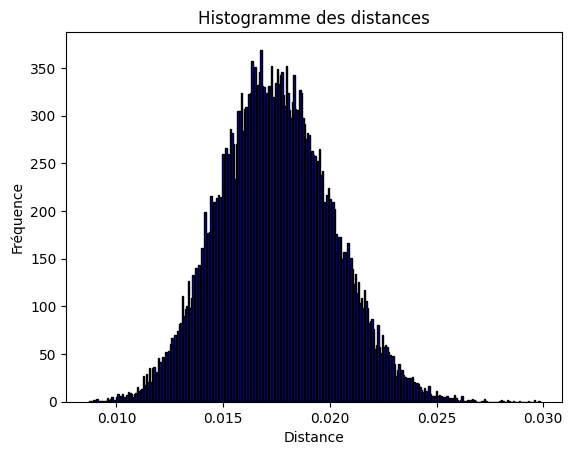

In [ ]:
seuil_volt = seuil('volt')

Le seuil ϑ basé sur un ajustement log-normale est: 0.025695191419444447


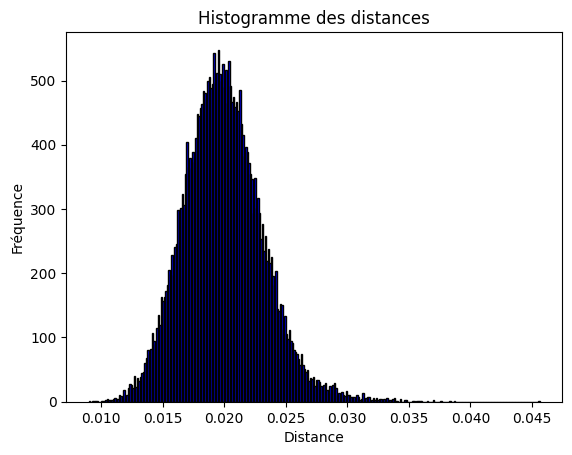

In [ ]:
seuil_pressure = seuil('pressure')

Le seuil ϑ basé sur un ajustement log-normale est: 0.03182107087160285


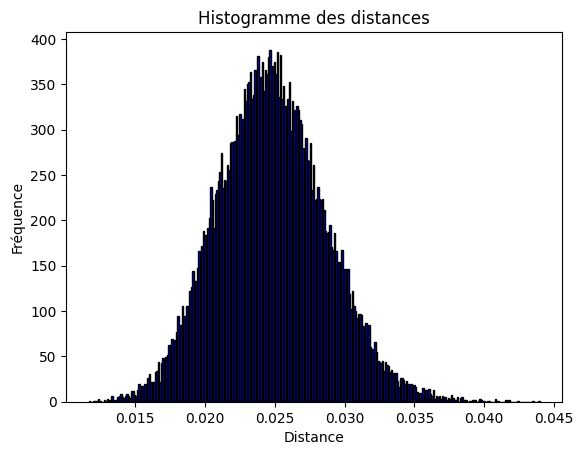

In [ ]:
seuil_vibration = seuil('vibration')

Le seuil ϑ basé sur un ajustement log-normale est: 0.029033217121294842


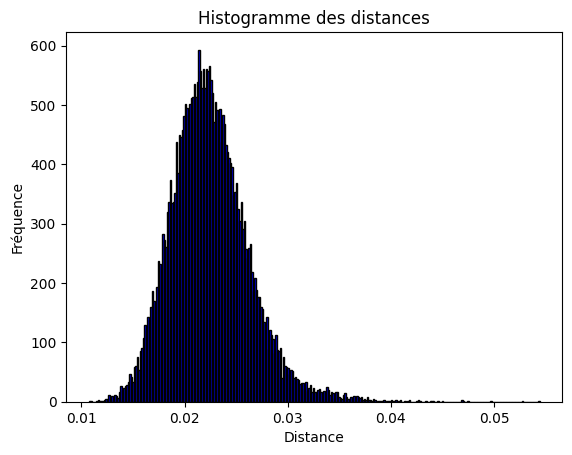

In [ ]:
seuil_rotate = seuil('rotate')

In [ ]:
seuils = {'volt' : seuil_volt, 'vibration' : seuil_vibration, 'pressure' : seuil_pressure, 'rotate' : seuil_rotate }
seuil_global = sum(seuil * poids[i] for i, seuil in enumerate(seuils.values()))
seuil_global

0.030831604478766057

# **Detection**

In [ ]:
def detection_model(y_pred):
    features = ['volt', 'rotate', 'pressure', 'vibration']
    distance_ponderee = 0

    for i, feature in enumerate(features):
        a = np.array(y_pred[feature]).reshape(-1, 1)
        b = barycentre(feature).reshape(-1, 1)
        a /= a.sum()
        b /= b.sum()

        # Calculate the cost matrix between the elements of a and b
        M = ot.dist(a, b, metric='euclidean')

        # Regularization term
        lambda_ = 1e-4  # Adjustable parameter

        # Compute the Sinkhorn distance
        sinkhorn_distance = ot.sinkhorn2(a, b, M, lambda_)[0]

        # Multiply the sinkhorn distance by the weight of the feature
        ponderee = sinkhorn_distance * poids[i]

        if ponderee < seuils[feature]:
            distance_ponderee += ponderee



    if distance_ponderee < seuil_global:
        return "Normal"
    else:
        return "Anormal"


In [ ]:
y_pred = daily_dfs[98]
print(list(np.array(y_pred['failure'])))
print(detection_model(y_pred))

[0, 0, 0, 0, 0, 0, 'comp1', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Normal


In [ ]:
y_pred = daily_dfs[9]
print(list(np.array(y_pred['failure'])))
print(detection_model(y_pred))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.0029486110395958026
0.0043058727780690064
0.0019269094017705358
0.004288340898993016
Normal


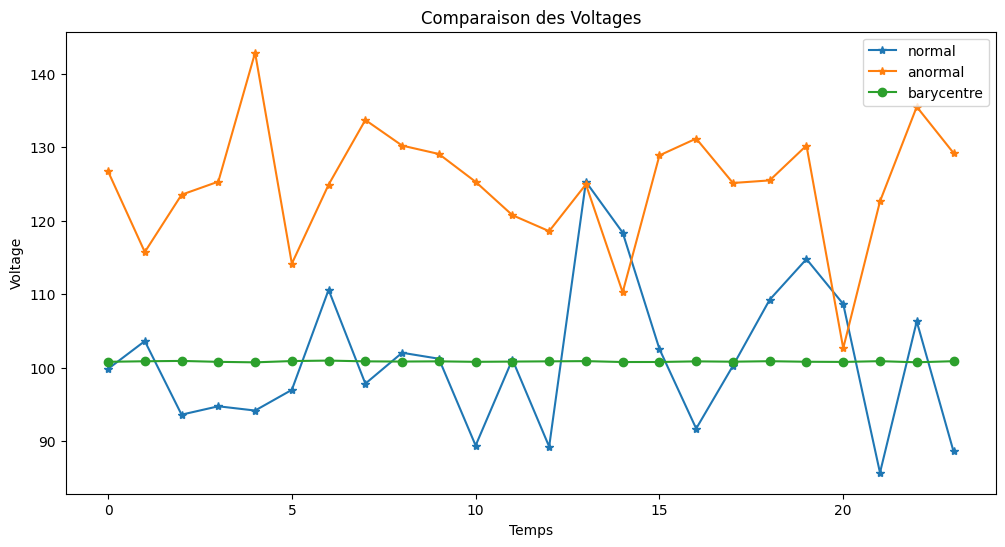

In [ ]:
features = ['volt', 'rotate', 'pressure', 'vibration']
par = features[2]
# Tracer les courbes
plt.figure(figsize=(12, 6))
plt.plot(daily_dfs[98]['heure'], daily_dfs[98][par], marker='*', label='normal')
plt.plot(daily_dfs[9]['heure'], daily_dfs[9][par], marker='*', label='anormal')
plt.plot(daily_dfs[9]['heure'], barycentres[par], marker='o', label='barycentre')

plt.title('Comparaison des Voltages')
plt.xlabel('Temps')
plt.ylabel('Voltage')
plt.legend()
plt.show()

In [ ]:
indice = []
result = []
for i in range(len(daily_dfs)):
  y_pred = daily_dfs[i]

  failure_list = list(np.array(y_pred['failure']))

  # Vérification si au moins un des éléments 'comp1', 'comp2', 'comp3', 'comp4' est dans la liste
  contains_comp = any(comp in failure_list for comp in ['comp1', 'comp2', 'comp3', 'comp4'])
  if contains_comp:
    result.append((i, detection_model(y_pred)))
    indice.append(i)

In [ ]:
print(indice)

[75, 98, 119, 136, 187, 258, 268, 283, 334, 342, 377, 402, 421, 474, 556, 588, 606, 731, 870, 1099, 1284, 1297, 1316, 1403, 1423, 1472, 1480, 1595, 1598, 1639, 1665, 1710, 1763, 1783, 1789, 1791, 1794, 1842, 1877, 1935, 1944, 2045, 2093, 2104, 2226, 2370, 2518, 2560, 2713, 2750, 2815, 2828, 2878, 2880, 2908, 2975, 2998, 3024, 3087, 3100, 3207, 3254, 3277, 3473, 3493, 3631, 3747, 3770, 3886, 3962, 4055, 4143, 4148, 4216, 4227, 4264, 4266, 4282, 4292, 4378, 4401, 4475, 4498, 4519, 4622, 4689, 4694, 4707, 4734, 4742, 4811, 4821, 4830, 4971, 4988, 5029, 5046, 5270, 5386, 5452, 5481, 5617, 5653, 5703, 5715, 5723, 5737, 5767, 5772, 5778, 5790, 5875, 5898, 5909, 5919, 5939, 5987, 6022, 6058, 6063, 6083, 6089, 6125, 6134, 6141, 6221, 6274, 6320, 6404, 6446, 6531, 6612, 6818, 6955, 7048, 7059, 7097, 7133, 7192, 7223, 7237, 7272, 7280, 7301, 7398, 7419, 7436, 7500, 7510, 7568, 7591, 7594, 7607, 7654, 7721, 7906, 8170, 8286, 8455, 8549, 8553, 8597, 8640, 8672, 8775, 8795, 8798, 8824, 8963, 8994, 

In [ ]:
result

In [ ]:
for i in range(0,50):
  c  = 0
  y_pred = daily_dfs[i]
  if 'comp1' or 'comp2' or 'comp3' or 'comp4' not in list(np.array(y_pred['failure'])):
    reality = 'Normal'
  else:
    reality = 'Anormal'
  detection = detection_model(y_pred)

  if detection == reality:
    c += 1

print( c / len(daily_dfs))


3.0959752321981425e-05


In [ ]:
y_pred = daily_dfs[115]
if 'comp1' or 'comp2' or 'comp3' or 'comp4' not in list(np.array(y_pred['failure'])):
  reality = 'Normal'
else:
  reality = 'Anormal'
detection = detection_model(y_pred)

print(detection)
print(reality)
